In [59]:
#@title Imports & Utils
#!pip install -q git+https://www.github.com/google/jax-md

import time

from functools import partial
import numpy as onp

import jax.numpy as np

from jax import jit
from jax import grad
from jax import vmap
from jax import value_and_grad

from jax import random
from jax import lax
import networkx as nx

from jax.example_libraries import stax
from jax.example_libraries import optimizers

from jax.config import config
config.update('jax_enable_x64', True)

# NOTE(schsam): We need this in OSS I think.
from IPython.display import HTML, display
import time

def ProgressIter(iter_fun, iter_len=0):
  if not iter_len:
    iter_len = len(iter_fun)
  out = display(progress(0, iter_len), display_id=True)
  for i, it in enumerate(iter_fun):
    yield it
    out.update(progress(i + 1, iter_len))

def progress(value, max):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 45%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Ellipse, Rectangle
from matplotlib.collections import PatchCollection

sns.set_style(style='white')
sns.set(font_scale=1.6)

def format_plot(x, y):
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)

def finalize_plot(shape=(1, 1)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1],
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

f32 = np.float32
f64 = np.float64

def draw_system(R, box_size, marker_size, color=None):
  if color == None:
    color = [64 / 256] * 3
  color = onp.array(color)
  ms = marker_size / box_size

  R = onp.array(R)

  marker_style = dict(
      linestyle='none',
      markeredgewidth=3,
      marker='o',
      markersize=ms,
      color=color,
      fillstyle='none')

  plt.plot(R[:, 0], R[:, 1], **marker_style)
  plt.plot(R[:, 0] + box_size, R[:, 1], **marker_style)
  plt.plot(R[:, 0], R[:, 1] + box_size, **marker_style)
  plt.plot(R[:, 0] + box_size, R[:, 1] + box_size, **marker_style)
  plt.plot(R[:, 0] - box_size, R[:, 1], **marker_style)
  plt.plot(R[:, 0], R[:, 1] - box_size, **marker_style)
  plt.plot(R[:, 0] - box_size, R[:, 1] - box_size, **marker_style)

  plt.xlim([0, box_size])
  plt.ylim([0, box_size])
  plt.axis('off')

def square_lattice(N, box_size):
  Nx = int(np.sqrt(N))
  Ny, ragged = divmod(N, Nx)
  if Ny != Nx or ragged:
    assert ValueError('Particle count should be a square. Found {}.'.format(N))
  length_scale = box_size / Nx
  R = []
  for i in range(Nx):
    for j in range(Ny):
      R.append([i * length_scale, j * length_scale])
  return np.array(R)

/tmp/ipykernel_871/1264776223.py:23: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


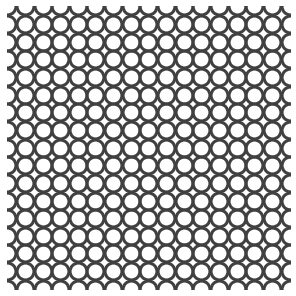

In [2]:
from jax_md import quantity

N = 256
box_size = quantity.box_size_at_number_density(particle_count=N,
                                               number_density=1.0,
                                               spatial_dimension=2)

r = square_lattice(N, box_size)
draw_system(r, box_size, 270.0)
finalize_plot((0.75, 0.75))

The positions, `r`, is just a numpy array and so we can shift the particles simply by adding a vector to `r`.

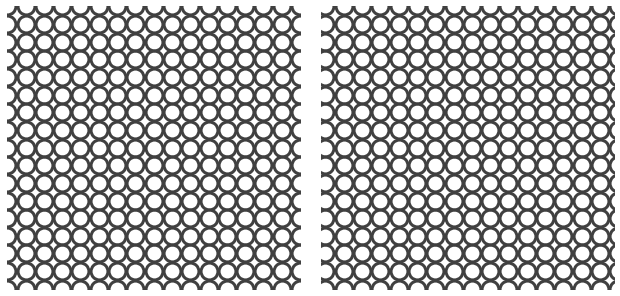

In [3]:
r_new = r + np.array([[0.25, 0]])

plt.subplot(1, 2, 1)
draw_system(r, box_size, 270.0)

plt.subplot(1, 2, 2)
draw_system(r_new, box_size, 270.0)

finalize_plot((1.5, 0.75))

Here, we are simulating a relatively small bubble raft. We can emulate a much larger bubble raft by combining our small simulation with periodic boundary conditions. Periodic boundary conditions are very common and they allow bubbles to wrap around the edges of the box like in the game "Asteroids". In JAX MD, we construct periodic boundary conditions using the function `space.periodic(box_size)` which returns a tuple of two functions, `(displacement_fn, shift_fn)`. The functions in the tuple do the following,

*   `dr_ij = displacement_fn(r_i, r_j)` takes a pair of positions and computes the displacement between them.
*   `r_p = shift_fn(r, delta_r)` takes a position and a shift and returns a new shifted position.

In [4]:
from jax_md import space

displacement_fn, shift_fn = space.periodic(box_size)

Next we need to posit interactions between our bubbles that simulate real bubbles. We'll assume that we can model a pair of bubbles by defining an energy function for the pair. We can use an energy that is zero if the bubbles aren't touching and then increases gradually as they get pushed together. Specifically, if $r_{ij}$ is the distance between bubble $i$ and $j$, we'll try out a function that looks like:

$$
U(r_{ij}) = \begin{cases}
  (1 - r_{ij})^2 & \text{if $r_{ij} < 1$} \\
  0 & \text{if $r_{ij}>1$}
  \end{cases}
$$  
When we run our simulation, by having bubbles move to try to minimize the energy between them they will naturally separate if they overlap.

This is implemented in JAX MD using the function `energy.soft_sphere(r)` which takes a distance and returns an energy.

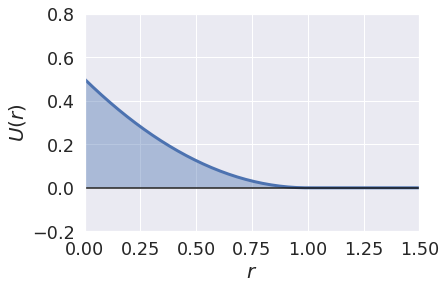

In [5]:
from jax_md import energy

dr = np.linspace(0, 3.0, num=80)
plt.plot(dr, energy.soft_sphere(dr), 'b-', linewidth=3)
plt.fill_between(dr, energy.soft_sphere(dr), alpha=0.4)

plt.gca().axhline(y=0, color='k')
plt.xlim([0, 1.5])
plt.ylim([-0.2, 0.8])

format_plot('$r$', '$U(r)$')

Once we've assigned an energy, $U(r_{ij})$, to pairs of bubbles, we have to assign an energy to to the whole system, $\mathcal U$. As we will see, our simulation will make use of the forces, $\vec F_i = -\nabla_{\vec r_i}\mathcal U$. This is usually done by just summing up all the pairwise energies,
$$\mathcal U = \frac12\sum_{ij}U(r_{ij}).$$
To compute the energy of the whole bubble raft in JAX, M.D. we use the helper function `energy_fn = energy.soft_sphere_pair(displacement_fn)` which returns a function that computes the soft-sphere energy for our bubble raft in its periodic box.

In [6]:
energy_fn = energy.soft_sphere_pair(displacement_fn)
print('Energy of the system, U = {:f}'.format(energy_fn(r)))

Energy of the system, U = 0.000000


In [7]:
key = random.PRNGKey(0)

## Optimization Through Dynamics

So far we have demonstrated how JAX MD can make common workloads easier. However, combining molecular dynamics with automatic differentiation opens the door for qualitatively new research. One such avenue involves differentiating through the simulation trajectory to optimize physical parameters. There have been several excellent applications so far in e.g. [protein folding](https://openreview.net/forum?id=Byg3y3C9Km), but until now this has involved significant amounts of specialized code. This vein of research is also similar to recent work in machine learning on [meta-optimization.](https://arxiv.org/abs/1606.04474)

Here we revisit the bubble raft example above. We will show how one can control the structure of the bubble raft by differentiating through the simulation. As we saw, bubble rafts form a hexagonal structure when all of the bubbles have the same size. However, when the bubbles have different sizes the situation can change considerably. To experiment with these changes, we're going to set up a simulation of a bubble raft with bubbles of two distinct sizes. To keep things simple, we'll let half of the bubbles have diameter $1$ and half have diameter $D$.

To control the conditions of the experiment, we will keep the total volume of the bubbles constant. To do this, note that if there are $N$ bubbles then the total volume of water filled by bubbles is,
$$V_{\text{bubbles}} = \frac N8\pi(D^2 + 1)$$
where the factor of $8$ comes from the fact that our system is split into two halves and we are using diameters not radii. Since the volume of our simulation is $V = L^2$ if we want to keep the "packing fraction", $\phi = V_{\text{bubbles}} / V$ constant then we will have to scale the size of the box to be,
$$L = \sqrt{\frac{V_{\text{bubbles}}}{\phi}}.$$
We begin by setting up some experiment parameters and writing a function to compute $L$ as a function of $D$.

In [8]:
N = 1024
N_2 = N // 2

simulation_steps = np.arange(300)
dt = 1e-2
temperature = 1e-5

key = random.PRNGKey(0)

packing_fraction = 0.9
markersize = 260

def box_size_at_packing_fraction(diameter):
  bubble_volume = N_2 * np.pi * (diameter ** 2 + 1) / 4
  return np.sqrt(bubble_volume / packing_fraction)

Now we write a simulation similar to the one in the Automatic Ensembling section. This time, however, will take a `diameter` in addition to a key. Additionally, unlike in the previous simulations where we only had one kind of bubble, this time we will have two. This is implemented here using the notion of bubble "species". We will split our bubble raft into two different species of bubbles that we will label $A$ and $B$ respectively. By having two different "species" of bubbles we can define different values of $\sigma$ for interactions between the different species. Since we have two different species this gives us three different $\sigma$ to define: $\sigma_{AA}$, $\sigma_{AB}$, and $\sigma_{BB}$. We know that $\sigma_{AA} = D$ and $\sigma_{BB} = 1$, but what should $\sigma_{AB}$ be? Since the $\sigma$ denote radii, it should be the case that $\sigma_{AB} = \frac12(D + 1)$. We can setup a helper function to setup the species now.

In [9]:
species = np.array([0] * (N_2) + [1] * (N_2), dtype=np.int32)

def species_sigma(diameter):
  d_AA = diameter
  d_BB = 1
  d_AB = 0.5 * (diameter + 1)
  return np.array(
      [[d_AA, d_AB],
       [d_AB, d_BB]]
  )

In [40]:
def circles(x, y, s, c='b', vmin=None, vmax=None, **kwargs):
    """
    Make a scatter plot of circles. 
    Similar to plt.scatter, but the size of circles are in data scale.
    Parameters
    ----------
    x, y : scalar or array_like, shape (n, )
        Input data
    s : scalar or array_like, shape (n, ) 
        Radius of circles.
    c : color or sequence of color, optional, default : 'b'
        `c` can be a single color format string, or a sequence of color
        specifications of length `N`, or a sequence of `N` numbers to be
        mapped to colors using the `cmap` and `norm` specified via kwargs.
        Note that `c` should not be a single numeric RGB or RGBA sequence 
        because that is indistinguishable from an array of values
        to be colormapped. (If you insist, use `color` instead.)  
        `c` can be a 2-D array in which the rows are RGB or RGBA, however. 
    vmin, vmax : scalar, optional, default: None
        `vmin` and `vmax` are used in conjunction with `norm` to normalize
        luminance data.  If either are `None`, the min and max of the
        color array is used.
    kwargs : `~matplotlib.collections.Collection` properties
        Eg. alpha, edgecolor(ec), facecolor(fc), linewidth(lw), linestyle(ls), 
        norm, cmap, transform, etc.
    Returns
    -------
    paths : `~matplotlib.collections.PathCollection`
    Examples
    --------
    a = np.arange(11)
    circles(a, a, s=a*0.2, c=a, alpha=0.5, ec='none')
    plt.colorbar()
    License
    --------
    This code is under [The BSD 3-Clause License]
    (http://opensource.org/licenses/BSD-3-Clause)
    """

    if np.isscalar(c):
        kwargs.setdefault('color', c)
        c = None

    if 'fc' in kwargs:
        kwargs.setdefault('facecolor', kwargs.pop('fc'))
    if 'ec' in kwargs:
        kwargs.setdefault('edgecolor', kwargs.pop('ec'))
    if 'ls' in kwargs:
        kwargs.setdefault('linestyle', kwargs.pop('ls'))
    if 'lw' in kwargs:
        kwargs.setdefault('linewidth', kwargs.pop('lw'))
    # You can set `facecolor` with an array for each patch,
    # while you can only set `facecolors` with a value for all.

    zipped = onp.broadcast(x, y, s)
    patches = [Circle((x_, y_), s_)
               for x_, y_, s_ in zipped]
    collection = PatchCollection(patches, **kwargs)
    if c is not None:
        c = onp.broadcast_to(c, zipped.shape).ravel()
        collection.set_array(c)
        collection.set_clim(vmin, vmax)

    ax = plt.gca()
    ax.add_collection(collection)
    ax.autoscale_view()
    plt.draw_if_interactive()
    if c is not None:
        plt.sci(collection)
    return collection

In [92]:
N = 4*100
N_2 = N // 4

simulation_steps = np.arange(500)
dt = 1e-2
temperature = 1e-5

key = random.PRNGKey(0)

packing_fraction = 1.2
markersize = 260

diameters = np.array([1.0, 0.85, 0.7, 0.55])
species = np.array([0] * (N_2) + [1] * (N_2) + [2] * (N_2) + [3] * (N_2), dtype=np.int32)

def species_sigma(diameters):
    diameter_matrix = np.tile(diameters, (diameters.shape[0],1)) 
    return 0.5* (diameter_matrix + diameter_matrix.T)

def box_size_at_packing_fraction(diameters, species, packing_fraction):
    
    bubble_volume = np.sum(np.pi * (diameters[species]**2)/4)
    return np.sqrt(bubble_volume / packing_fraction)

We will feed the `species` and `sigma` definitions into the `energy.soft_sphere_pair` function. We will also have our simulation return three things: the box size, the final energy, and the final positions. Unlike the previous simulations, we will minimize the energy of the system instead of simulating using brownian motion. To do this we will use the minimizer, `init_fun, apply_fun = minimize.fire_descent(energy_fun, shift_fun)` provided by JAX MD.

In [105]:
from jax_md import minimize

def simulation(diameters, packing_fraction, key):
  box_size = box_size_at_packing_fraction(diameters, species, packing_fraction)
  displacement, shift = space.periodic(box_size)

  sigma = species_sigma(diameters)
  energy_fn = energy.soft_sphere_pair(
      displacement, species=species, sigma=sigma)

  pos_key, sim_key = random.split(key)

  R = random.uniform(pos_key, (N, 2), maxval=box_size)

  init_fn, apply_fn = minimize.fire_descent(energy_fn, shift)
  state = init_fn(R)

  do_step = lambda state, t: (apply_fn(state, t=t), ())
  state, _ = lax.scan(do_step, state, simulation_steps)

  return box_size, energy_fn(state.position), state.position

Now let's run simulations with two different values of $D$ and draw them side-by-side. In one case we will use $D = 1$ so that both species are the same and this will result in the same hexagonal configuration as in the warm up. However, we will then run a simulation with $D = 0.8$ to see what happens when all the bubbles don't have the same size.

In [106]:
def simulate_and_show(diameters, packing_fraction):
    box_size, raft_energy, bubble_positions = simulation(diameters, packing_fraction, key)
    fig_length = 5 #inches
    dots_per_inch = 100
    fig, ax = plt.subplots(figsize=(fig_length, fig_length), dpi = dots_per_inch)
    bubble_positions = bubble_positions- box_size* np.rint(bubble_positions/box_size)
    circles(bubble_positions[:,0],bubble_positions[:,1], 0.5*diameters[species], fc = 'None', ec = 'k')
    ax.axis('equal')
    return box_size, raft_energy, bubble_positions

The hexagonal structure when the bubbles have the same size has broken down in the two-species case. To get a bit more insight into this we will use the automatic vectorization capabilities to see how the structure and energy of bubble rafts depends on `diameter`.

In [139]:
def createGraphFromPositions(N, bubble_positions, diameters, species, box_size):
    X = onp.array(bubble_positions, dtype = np.float64)
    r_c = 0.5*( onp.tile(diameters[species],(N,1)) + onp.tile(diameters[species],(N,1)).T)
    Q=X/box_size
    T=np.tile(Q,(N,1,1))
    T2=np.moveaxis(T,0,1)
    TD=T-T2
    TDN=TD-onp.rint(TD)
    TDR=box_size*TDN

    E1=onp.array(np.where(np.linalg.norm(TDR,axis=2)<r_c))
    E=onp.transpose(E1[:,E1[0]>E1[1]])
    
    G = nx.Graph()
    G.add_nodes_from(range(N))
    G.add_edges_from(E)
    E = onp.array(G.edges)
    L = onp.linalg.norm(X[E[:, 0], :] - X[E[:, 1], :], axis=1)
    if np.sum(L<0.1)>0:
        print('issue')
    return N, G, X, E
    

In [140]:
def plotGraph(N,G,X):
    fig_length = 5 #inches
    dots_per_inch = 100
    fig, ax = plt.subplots(figsize=(fig_length, fig_length), dpi = dots_per_inch)
    pos = {i: (X[i, 0], X[i, 1]) for i in range(N)}
    nx.draw_networkx_edges(G,pos)
    plt.axis('equal')
    return

Array(3, dtype=int64)

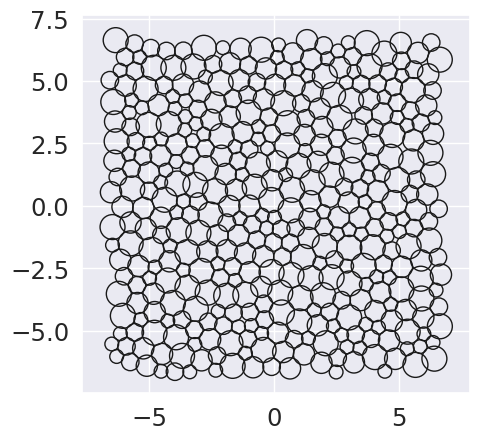

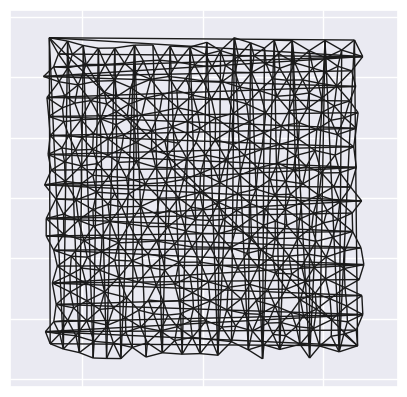

In [141]:
box_size, raft_energy, bubble_positions = simulate_and_show(diameters, 1.1)
N, G, X, E = createGraphFromPositions(N, bubble_positions, diameters, species,box_size)
plotGraph(N,G,X)
np.min(np.transpose(np.array(G.degree()))[1]) #degrees

In [142]:
nx.check_planarity(G)

(False, None)

In [124]:
ensemble_size = 40

# Vectorize over both random keys and diameter.
vec_simulation = vmap(vmap(simulation, (None, 0)), (0, None))

sim_keys = random.split(key, ensemble_size)
diameter = np.linspace(0.4, 1.0, 10)

box_size, raft_energy, bubble_positions = vec_simulation(diameter, sim_keys)

TypeError: simulation() missing 1 required positional argument: 'key'

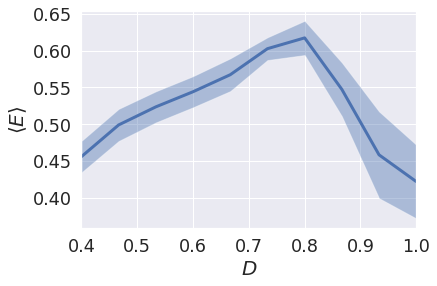

In [ ]:
E_mean = np.mean(raft_energy, axis=1)
E_std = np.std(raft_energy, axis=1)

plt.plot(diameter, E_mean, linewidth=3)
plt.fill_between(diameter, E_mean + E_std, E_mean - E_std, alpha=0.4)

plt.xlim([0.4, 1.0])

format_plot('$D$', '$\\langle E\\rangle$')

At small values of the diameter, the energy is low and increases with increasing diameter until a maximum in the energy at which point it drops precipitously. We can visualize an example system at each of these diameter disparities to see what is happening. We will color the bubble rafts by their energy.

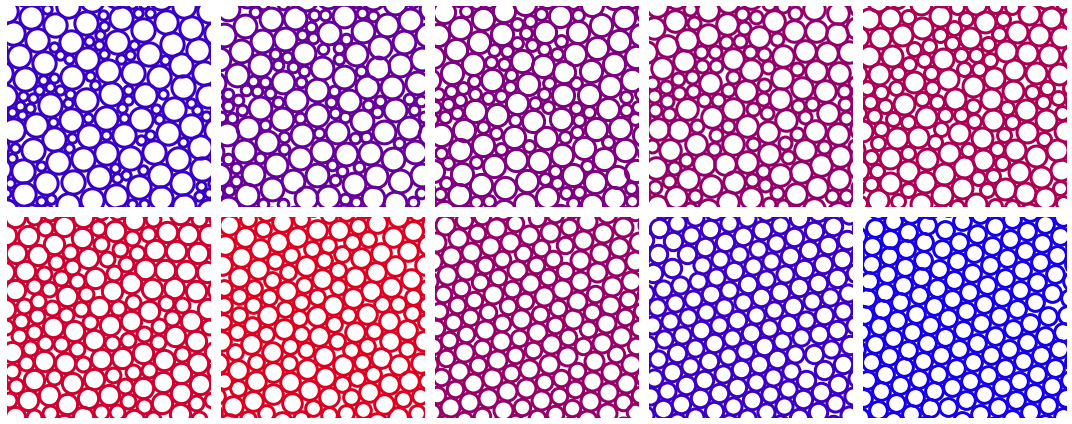

In [ ]:
ms = 180
for i, d in enumerate(diameter):
  # if i % 2:
  #   continue
  plt.subplot(2, 5, i + 1)
  c = min(1, max(0, (E_mean[i] - 0.4) * 4))
  color = [c, 0, 1 - c]
  draw_system(bubble_positions[i, 0, :N_2], box_size[i, 0], d * ms, color=color)
  draw_system(bubble_positions[i, 0, N_2:], box_size[i, 0], ms, color=color)

finalize_plot((2.5, 1))

Notice that when the diameter of the smaller bubbles is very smaller-than or equal-to that of the larger ones, the structure looks much more hexagonal. However, when the diameter is in-between (where the energy is high) the bubbles end up looking like they are arranged randomly. This is an effect known as the [Jamming transition.](https://) However, could we have found this optimally disordered region without brute force? Let's try to maximize the energy with respect to the diameter, $D$, directly.

To do this, we will run short simulation trajectories starting with the positions after minimization that we found above. At the end of the short simulation we will compute the energy of the bubble raft. We will then take the derivative of the energy after the short simulation with respect to the particle diameter.  We're going to make use of the JAX's `grad` function. The function `df_dx = grad(f)` takes a function and returns a new function that computes its gradient with respect to its first argument. Let's now write a shorter simulation function and have it just return the final energy of the system.

In [ ]:
short_simulation_steps = np.arange(10)
def short_simulation(diameter, positions, key):
  box_size = box_size_at_packing_fraction(diameter)
  R = positions / box_size
  displacement, shift = space.periodic_general(box_size * np.eye(2))

  sigma = species_sigma(diameter)
  energy_fn = energy.soft_sphere_pair(
      displacement, species=species, sigma=sigma)

  init_fn, apply_fn = minimize.gradient_descent(energy_fn, shift, 1e-3)
  state = init_fn(R)

  do_step = lambda state, t: (apply_fn(state, t=t), ())
  state, _ = lax.scan(do_step, state, short_simulation_steps)

  return energy_fn(state)

Next, let's take the derivative of the energy with respect to the particle diameters and vectorize it over the ensemble of initial positions.


In [ ]:
dE_dD_fun = grad(short_simulation)
dE_dD_fun = jit(vmap(dE_dD_fun, (None, 0, 0)))

Now, we run the simulation for each diameter and record the gradients over each member of the ensemble. We then plot the average gradient against diameter and compare it with the energy that we found by directly simulating the bubble raft.

In [ ]:
dE_dD = []
for i, d in ProgressIter(enumerate(diameter), len(diameter)):
  key, split = random.split(key)
  split = random.split(split, ensemble_size)
  dE_dD += [dE_dD_fun(d, bubble_positions[i], split)]
dE_dD = np.array(dE_dD)

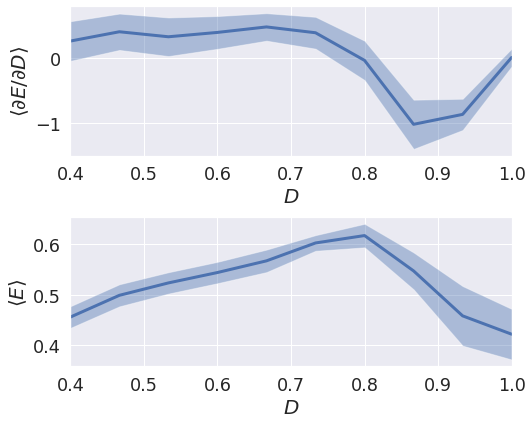

In [ ]:
plt.subplot(2, 1, 1)

dE_mean = np.mean(dE_dD, axis=1)
dE_std = np.std(dE_dD, axis=1)

plt.plot(diameter, dE_mean, linewidth=3)
plt.fill_between(diameter, dE_mean + dE_std, dE_mean - dE_std, alpha=0.4)

plt.xlim([0.4, 1.0])
format_plot('$D$', '$\\langle \\partial E/\\partial D\\rangle$')

plt.subplot(2, 1, 2)
plt.plot(diameter, E_mean, linewidth=3)
plt.fill_between(diameter, E_mean + E_std, E_mean - E_std, alpha=0.4)

plt.xlim([0.4, 1.0])

format_plot('$D$', '$\\langle E\\rangle$')

finalize_plot((1.25, 1))

We see that the gradient is positive and constant for $D < 0.8$ corresponding to the linear increase in the average energy. Moreover, we see that the derivative crosses zero exactly at the maximum average energy. Finally, we observe that the gradient goes back to zero at $D = 1$. This suggests that $D = 0.8$ is the point of maximum disorder, as we found by brute force above. It also shows that $D = 1$ is the minimum energy configuration of the diameter. Although we hadn't hypothesized it, we realize this must be true since $D < 1$ states are symmetric with $D > 1$ as we keep the total packing fraction constant.